In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('/content/bankloan.csv')

In [3]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
data.shape

(614, 13)

In [5]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

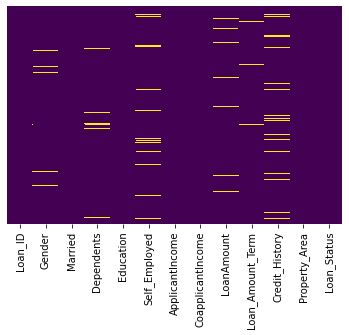

In [6]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

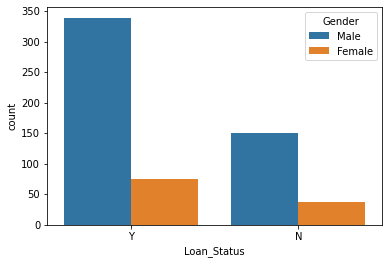

In [7]:
sns.countplot(x='Loan_Status',hue='Gender', data=data)

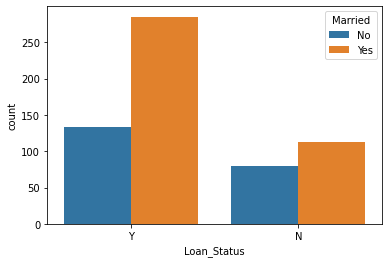

In [8]:
sns.countplot(x='Loan_Status',hue='Married', data=data)

In [9]:
# handling missing value
data['Credit_History'] = data['Credit_History'].fillna(data['Credit_History'].mode()[0])
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0])
data['LoanAmount'] = data['LoanAmount'].fillna(data['LoanAmount'].mode()[0])
data['Dependents'] = data['Dependents'].fillna(data['Dependents'].mode()[0])
data['Married'] = data['Married'].fillna(data['Married'].mode()[0])
data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])
data['Self_Employed'] = data['Self_Employed'].fillna(data['Self_Employed'].mode()[0])

In [10]:
data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [11]:
#imbalance data check
data['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

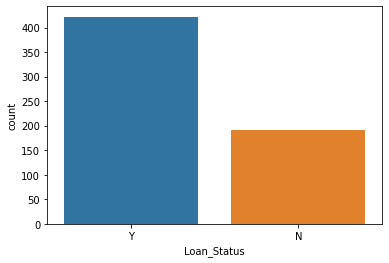

In [12]:
sns.countplot(x='Loan_Status',data=data)

In [13]:
# x feature and y feature split
x = data.iloc[:,1:12]
y = data['Loan_Status']

In [14]:
y = y.map(dict(Y=1, N=0))

In [15]:
x = pd.get_dummies(x)

In [16]:
# handling imbalance data
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
x, y = smote.fit_resample(x,y)

In [17]:
y.value_counts()

1    422
0    422
Name: Loan_Status, dtype: int64

In [19]:
# dividing dataset into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=40)

In [20]:
# scaling the features
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()

In [21]:
x_train = ms.fit_transform(x_train)
x_test = ms.transform(x_test)

In [22]:
#building logistic regression model
from sklearn.linear_model import LogisticRegression
lrm = LogisticRegression()

In [23]:
lrm.fit(x_train,y_train)

LogisticRegression()

In [25]:
#chcking model performance
y_pred = lrm.predict(x_test)
x_pred = lrm.predict(x_train)

In [26]:
from sklearn.metrics import accuracy_score
test_set_accur = accuracy_score(y_pred,y_test)
train_set_accur = accuracy_score(x_pred,y_train)

In [27]:
print(f'testing accuracy is {test_set_accur}')
print(f'training accuracy is {train_set_accur}')

testing accuracy is 0.8461538461538461
training accuracy is 0.8548148148148148


In [29]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.2 MB/s 
     |████████████████████████████████| 1.6 MB 55.2 MB/s 


In [30]:
# building neural network
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from keras import Sequential
from keras.layers import Dense

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  after removing the cwd from sys.path.


In [31]:
def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 2, 20)):
    model.add(layers.Dense(units=hp.Int('units_'+str(i),
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
           hp.Choice('learning_rate',[1e-2, 1e-3, 1e-4])),
           loss = 'binary_crossentropy',
           metrics=['accuracy'])
    return model

In [32]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial = 3,
    directory = 'project',
    project_name = 'Air Quality Index'
)

In [33]:
tuner.search(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

Trial 5 Complete [00h 00m 04s]
val_accuracy: 0.7850098609924316

Best val_accuracy So Far: 0.8461538354555765
Total elapsed time: 00h 00m 21s


In [34]:
tuner.results_summary()

Results summary
Results in project/Air Quality Index
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
units_0: 192
learning_rate: 0.01
Score: 0.8461538354555765
Trial summary
Hyperparameters:
num_layers: 15
units_0: 384
learning_rate: 0.001
Score: 0.8205128312110901
Trial summary
Hyperparameters:
num_layers: 11
units_0: 64
learning_rate: 0.001
Score: 0.7850098609924316
Trial summary
Hyperparameters:
num_layers: 5
units_0: 96
learning_rate: 0.001
Score: 0.7751479347546896
Trial summary
Hyperparameters:
num_layers: 6
units_0: 512
learning_rate: 0.0001
Score: 0.635108490784963


In [37]:
neural = Sequential()
neural.add(Dense(192, activation='relu',kernel_initializer='random_normal',input_dim=x_test.shape[1]))
neural.add(Dense(40, activation='relu',kernel_initializer='random_normal' ))
neural.add(Dense(10, activation='relu', kernel_initializer='random_normal')) 
neural.add(Dense(1, activation='relu', kernel_initializer='random_normal'))
neural.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
neural.fit(x_train,y_train,batch_size=20, epochs=100,verbose=0)


In [38]:
eval_neural = neural.evaluate(x_train,y_train)
eval_neural

22/22 [==============================] - 0s 2ms/step - loss: 0.3070 - accuracy: 0.8696


[0.30696815252304077, 0.8696296215057373]

*pickling the model*.
neural network did well as compare to logistic regression,
therefore we are pickling the neural network

In [39]:
import pickle
import joblib
filename = 'loanmodel.pkl'
joblib.dump(neural,filename)

['loanmodel.pkl']

In [40]:
mdl = joblib.load('/content/loanmodel.pkl')

In [41]:
#building a prediction system

p = (3,4500,1500,1285000,360,1,0,1,0,1,1,0,1,0,1,0,0)
p = np.asarray(p)
p = p.reshape(1,-1)
p = ms.transform(p)

prediction = mdl.predict(p)
print(prediction)
if prediction >= 0.45:
  print('your loan has been approved')
else:
  print('you do not qualify for a loan')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


1/1 [==============================] - 0s 172ms/step
[[0.]]
you do not qualify for a loan
